# Bitcoin Price Prediction

## Import Modules

In [51]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import tensorflow as tf
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

## Data Analysis

In [21]:
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440 entries, 0 to 3439
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3440 non-null   object 
 1   Open       3440 non-null   float64
 2   High       3440 non-null   float64
 3   Low        3440 non-null   float64
 4   Close      3440 non-null   float64
 5   Adj Close  3440 non-null   float64
 6   Volume     3440 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 188.3+ KB


In [25]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3440.000000,3440.000000,3440.000000,3440.000000,3440.000000,3.440000e+03
mean,14973.754519,15322.355353,14601.725605,14987.384544,14987.384544,1.668123e+10
std,16437.815391,16829.573070,16005.961724,16445.117775,16445.117775,1.902637e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,954.605255,974.954483,920.671982,963.116730,963.116730,1.827230e+08
50%,8367.229981,8597.199218,8183.028320,8371.758301,8371.758301,1.204004e+10
75%,25841.673828,26128.278809,25437.442383,25855.629883,25855.629883,2.701202e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


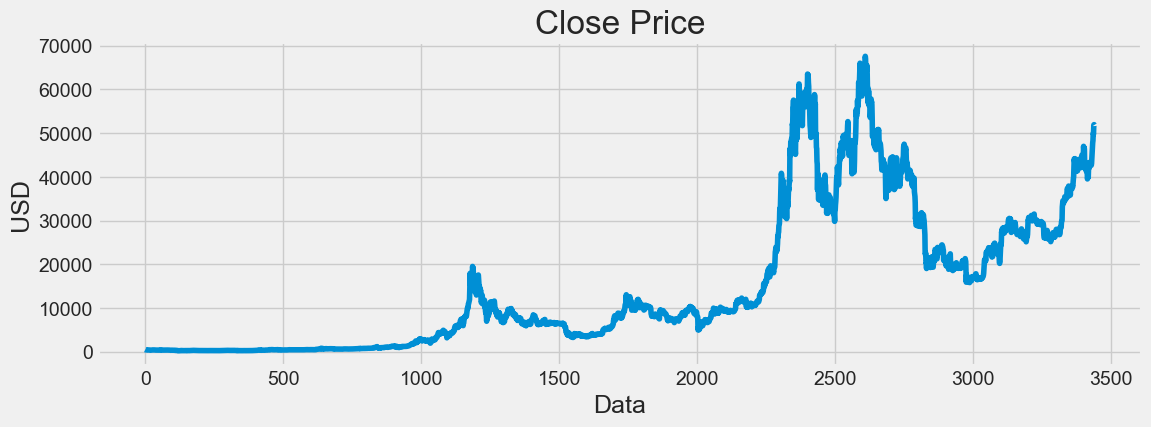

In [94]:
plt.figure(figsize=(12,4))
plt.title('Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

## Data Preprocessing

In [33]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8) # We are using %80 of the data for training
training_data_len

2752

In [35]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.7664278 ],
       [0.76808771],
       [0.766641  ]])

In [37]:
train_data = scaled_data[0:training_data_len, :]
X_train = []
y_train = []

for i in range(60, len(train_data)):
  X_train.append(train_data[i-60: i, 0])
  y_train.append(train_data[i, 0])

  if i <= 60:
    print(X_train)
    print(y_train)
    print()

[array([0.00414359, 0.00365546, 0.00321557, 0.00342492, 0.0032753 ,
       0.00332473, 0.0038239 , 0.00363714, 0.00346454, 0.00335845,
       0.00328567, 0.00295417, 0.00292874, 0.00309905, 0.00304965,
       0.00292288, 0.00269198, 0.00223721, 0.00211322, 0.00225521,
       0.00234585, 0.00259445, 0.0027738 , 0.0027224 , 0.00273334,
       0.00297447, 0.00315054, 0.0033057 , 0.00321523, 0.00303393,
       0.00305177, 0.0031658 , 0.00313766, 0.00303822, 0.00309209,
       0.00304287, 0.00267573, 0.00267466, 0.00251033, 0.00262063,
       0.00259518, 0.00266387, 0.00233701, 0.00248116, 0.00237752,
       0.00219096, 0.00219308, 0.00221774, 0.00226134, 0.00239481,
       0.00254029, 0.00243827, 0.00248387, 0.00274766, 0.00280197,
       0.00281341, 0.00364242, 0.00360048, 0.00326041, 0.00293862])]
[0.0031129686991635463]



In [39]:
len(X_train)

2692

In [41]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2692, 60), (2692,))

In [43]:
test_data = scaled_data[training_data_len - 60 : , :]
X_test = []
y_test = dataset[training_data_len : , :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60 : i, 0])

In [47]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Model 1

In [53]:
tf.random.set_seed(42)
model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) , the simple form is "input_shape(60, 1)""
model_1.add(LSTM(50, return_sequences=False))
model_1.add(Dense(25))
model_1.add(Dense(1))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
model_1.compile(optimizer='adam', loss='mse')

In [59]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 0.0023
Epoch 2/10
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 8.3285e-04
Epoch 3/10
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 5.8821e-04
Epoch 4/10
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 4.7055e-04
Epoch 5/10
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 4.2679e-04
Epoch 6/10
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 3.8935e-04
Epoch 7/10
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 3.7554e-04
Epoch 8/10
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 3.6230e-04
Epoch 9/10
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 3.4745e-04
Epoch 10/10
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 3.4089e-04


## Model 2

In [63]:
tf.random.set_seed(42)
model_2 = Sequential()
model_2.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) | the simple form is "input_shape(60, 1)
model_2.add(LSTM(50, return_sequences=False))
model_2.add(Dense(25))
model_2.add(Dense(1))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
model_2.compile(optimizer='Adam', loss='mse')
history_2 = model_2.fit(X_train, y_train, batch_size=1, epochs=6)

Epoch 1/6
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.0060
Epoch 2/6
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 9.4335e-04
Epoch 3/6
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 6.2255e-04
Epoch 4/6
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 4.9402e-04
Epoch 5/6
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 4.3306e-04
Epoch 6/6
2692/2692 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 4.0814e-04


## Model Evaluation

In [67]:
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
len(predictions_1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


688

In [69]:
rmse = np.sqrt(np.mean(predictions_1 - y_test)**2)
rmse

63.26434887127548

<Figure size 400x200 with 0 Axes>

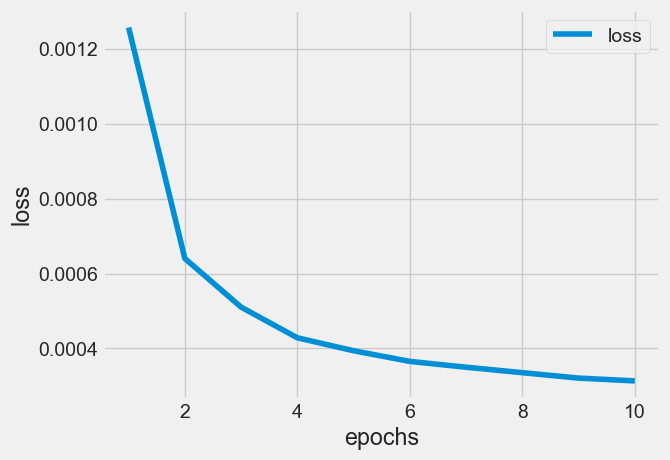

In [100]:
plt.figure(figsize=(4, 2))
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

In [73]:
predictions_2 = model_2.predict(X_test)
predictions_2 = scaler.inverse_transform(predictions_2)
len(predictions_2)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


688

In [75]:
rmse_2 = np.sqrt(np.mean(predictions_2 - y_test)**2)
rmse_2

238.69228906250004

<Figure size 400x200 with 0 Axes>

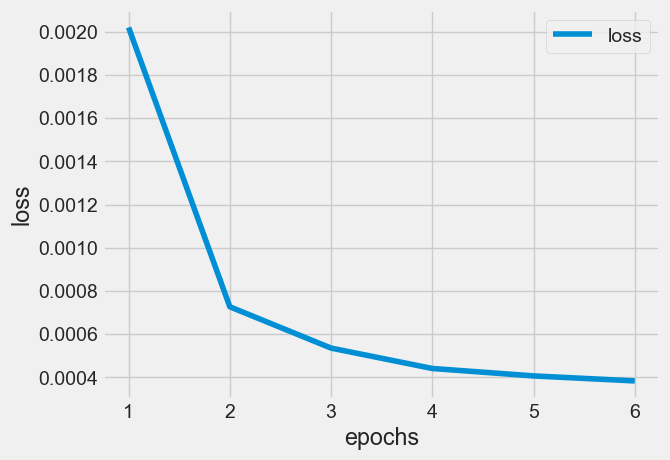

In [102]:
plt.figure(figsize=(4, 2))
historyForPlot = pd.DataFrame(history_2.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

## Prediction -- Model 1

/var/folders/b2/lvqrh_ls7kv5ml5c2g7djdgw0000gn/T/ipykernel_61066/860623882.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_1['Predictions'] = predictions_1


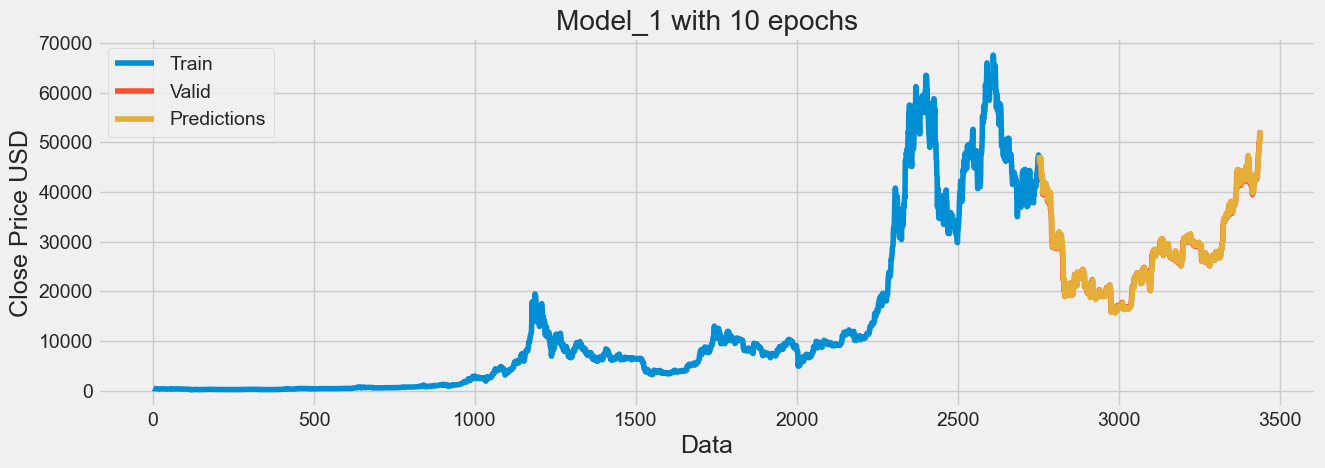

In [86]:
train = data[:training_data_len]

valid_1 = data[training_data_len:]
valid_1['Predictions'] = predictions_1

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model_1 with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_1[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')
plt.show()

## Prediction -- Model 2

/var/folders/b2/lvqrh_ls7kv5ml5c2g7djdgw0000gn/T/ipykernel_61066/524080289.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_2['Predictions'] = predictions_2


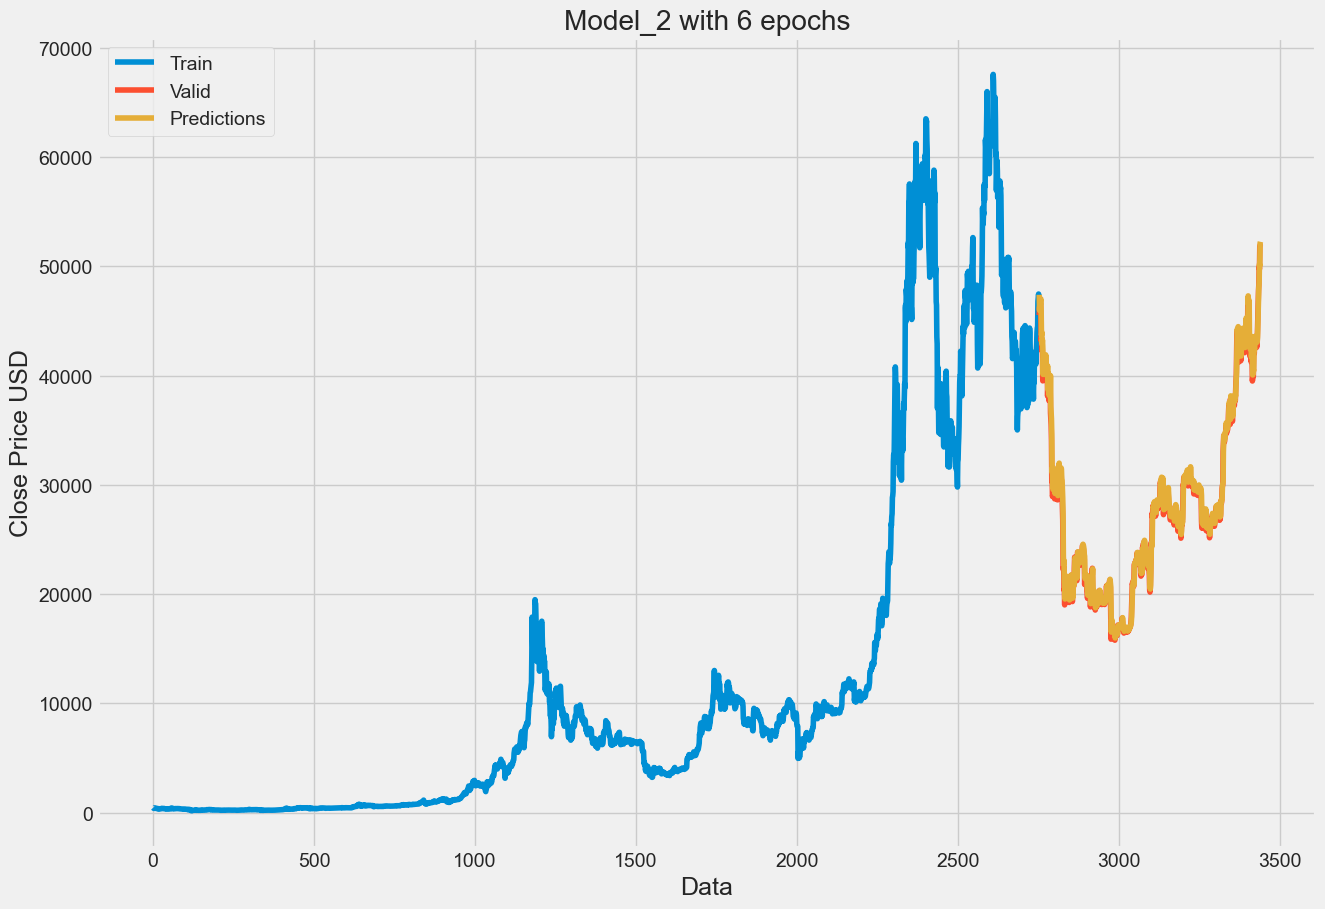

In [91]:
train = data[:training_data_len]

valid_2 = data[training_data_len:]
valid_2['Predictions'] = predictions_2

plt.figure(figsize=(14, 10))
plt.title('Model_2 with 6 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_2[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')
plt.show()